In [166]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from pandas.plotting import lag_plot, autocorrelation_plot
%run ../src/models/section_series.py
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

In [6]:
series_loader = SectionSeriesLoader(
    img_shape=(200, 200),
    SRC_PATH='../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/*.npz')

In [7]:
def plot_series(series):
    max_abs = max(abs(series.max()), abs(series.min()))
    fig, ax = plt.subplots(5,4,figsize=(20,20))
    for i, axi in enumerate(ax.flat):
        axi.imshow(series[i], vmin=-max_abs, vmax=max_abs, cmap='RdBu')
        axi.set(xticks=[], yticks=[])

    plt.show()

## Haiti Series

In [34]:
%%time
haiti_series = series_loader.load({'lat':18.53,'lng':-72.34})

Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F101993.v4b_web.stable_lights.avg_vis.tif.npz


KeyboardInterrupt: 

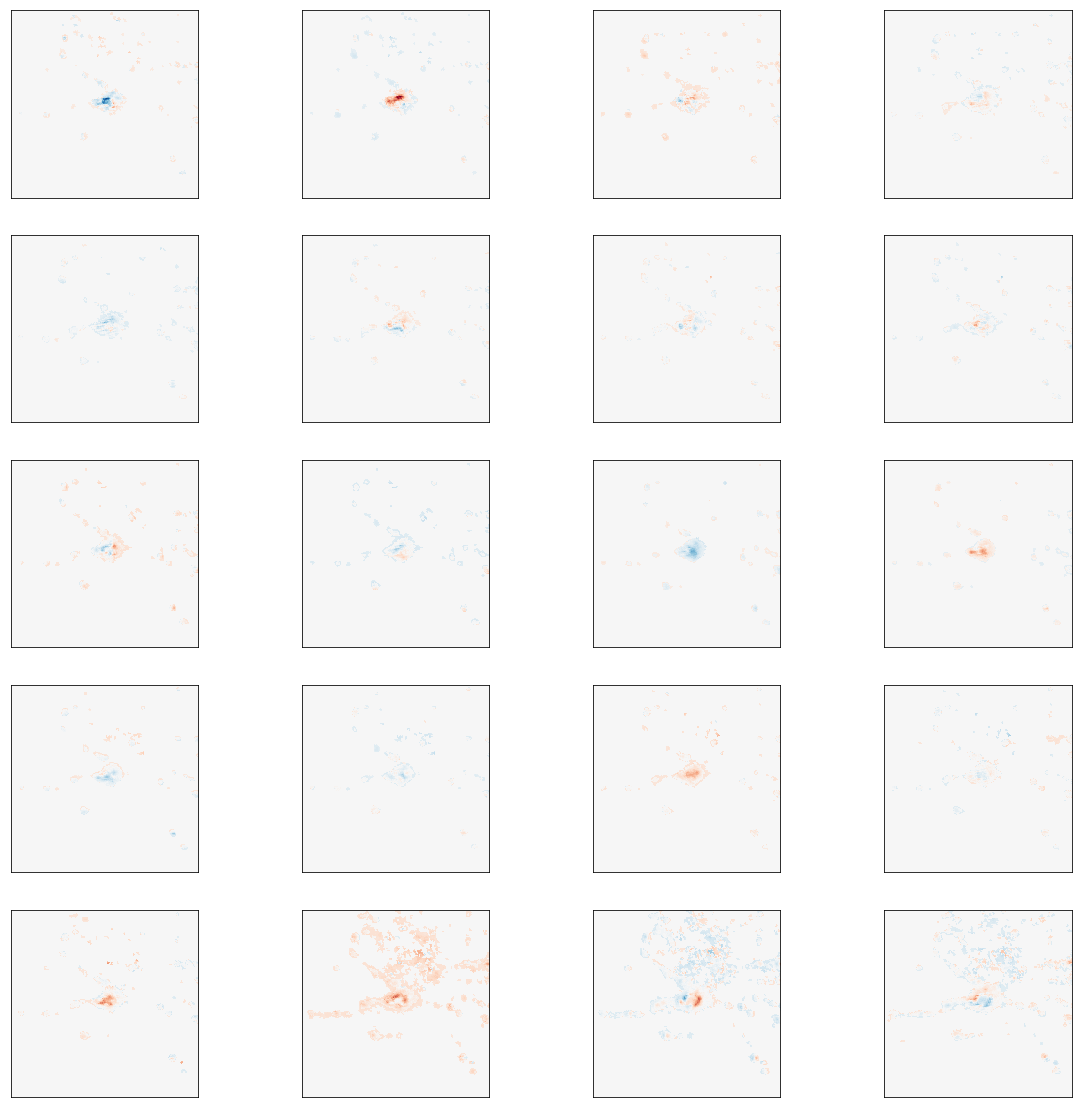

In [29]:
plot_series(haiti_series)

In [134]:
haiti_series_means = haiti_series.mean(axis=(1,2))
haiti_series_means

NameError: name 'haiti_series' is not defined

In [31]:
df_haiti_series = pd.DataFrame({
    'mean_change': haiti_series_means
}, index=range(1993,2014))
df_haiti_series.head()

,mean_change
1993,0.003050
1994,-0.004425
1995,-0.133050
1996,-0.002050
1997,0.099150


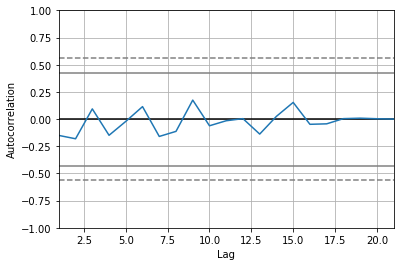

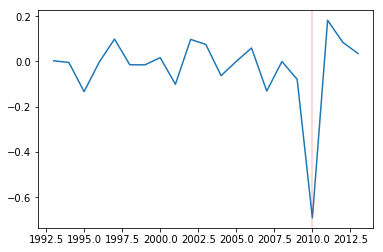

In [32]:
autocorrelation_plot(df_haiti_series['mean_change'])
plt.show()
plt.plot(df_haiti_series['mean_change'])
plt.axvline(x=2010, c='r', lw=.3)
plt.show()
None

## Multiple Series

In [203]:
earthquakes = pd.read_csv('../data/raw/USGSEarthquakeHazards/USGSEarthquakeHazards.csv', index_col=0)
earthquakes = earthquakes[abs(earthquakes['latitude']) < 62] # otherwise it get's malformed images
earthquakes = earthquakes[abs(earthquakes['longitude']) < 177] # same here
earthquakes['year'] = earthquakes['time'].apply(lambda x: int(x[:4]))
earthquakes = earthquakes[earthquakes['year'] < 2013]
earthquakes = earthquakes[earthquakes['year'] > 1993]
earthquakes_sorted = earthquakes.sort_values('mag', ascending=False)
earthquakes_sorted[['year','place','mag']].head(25)

,year,place,mag
44879,2011,"near the east coast of Honshu, Japan",9.1000
28763,2004,off the west coast of northern Sumatra,9.1000
42284,2010,"offshore Bio-Bio, Chile",8.8000
46467,2012,off the west coast of northern Sumatra,8.6000
31414,2005,"northern Sumatra, Indonesia",8.6000
25204,2001,near the coast of southern Peru,8.4000
34673,2007,"southern Sumatra, Indonesia",8.4000
32315,2006,Kuril Islands,8.3000
27589,2003,"Hokkaido, Japan region",8.3000
8825,1994,Kuril Islands,8.3000


In [185]:
%run ../src/models/section_series.py
target_coords_list = [{'lat': r[0],'lng': r[1]} for r
    in earthquakes_sorted[['latitude', 'longitude']].values[:3500]]
series_loader = SectionSeriesLoader(
    SRC_PATH='../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/*.npz')
series = series_loader.load_multiple(target_coords_list)

Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F101993.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121994.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121995.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F121996.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141997.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141998.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F141999.v4b_web.stable_lights.avg_vis.tif.npz
Loading file ../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/F142000.v4b_web.stable_lights.avg_vis.tif.npz
Loading 

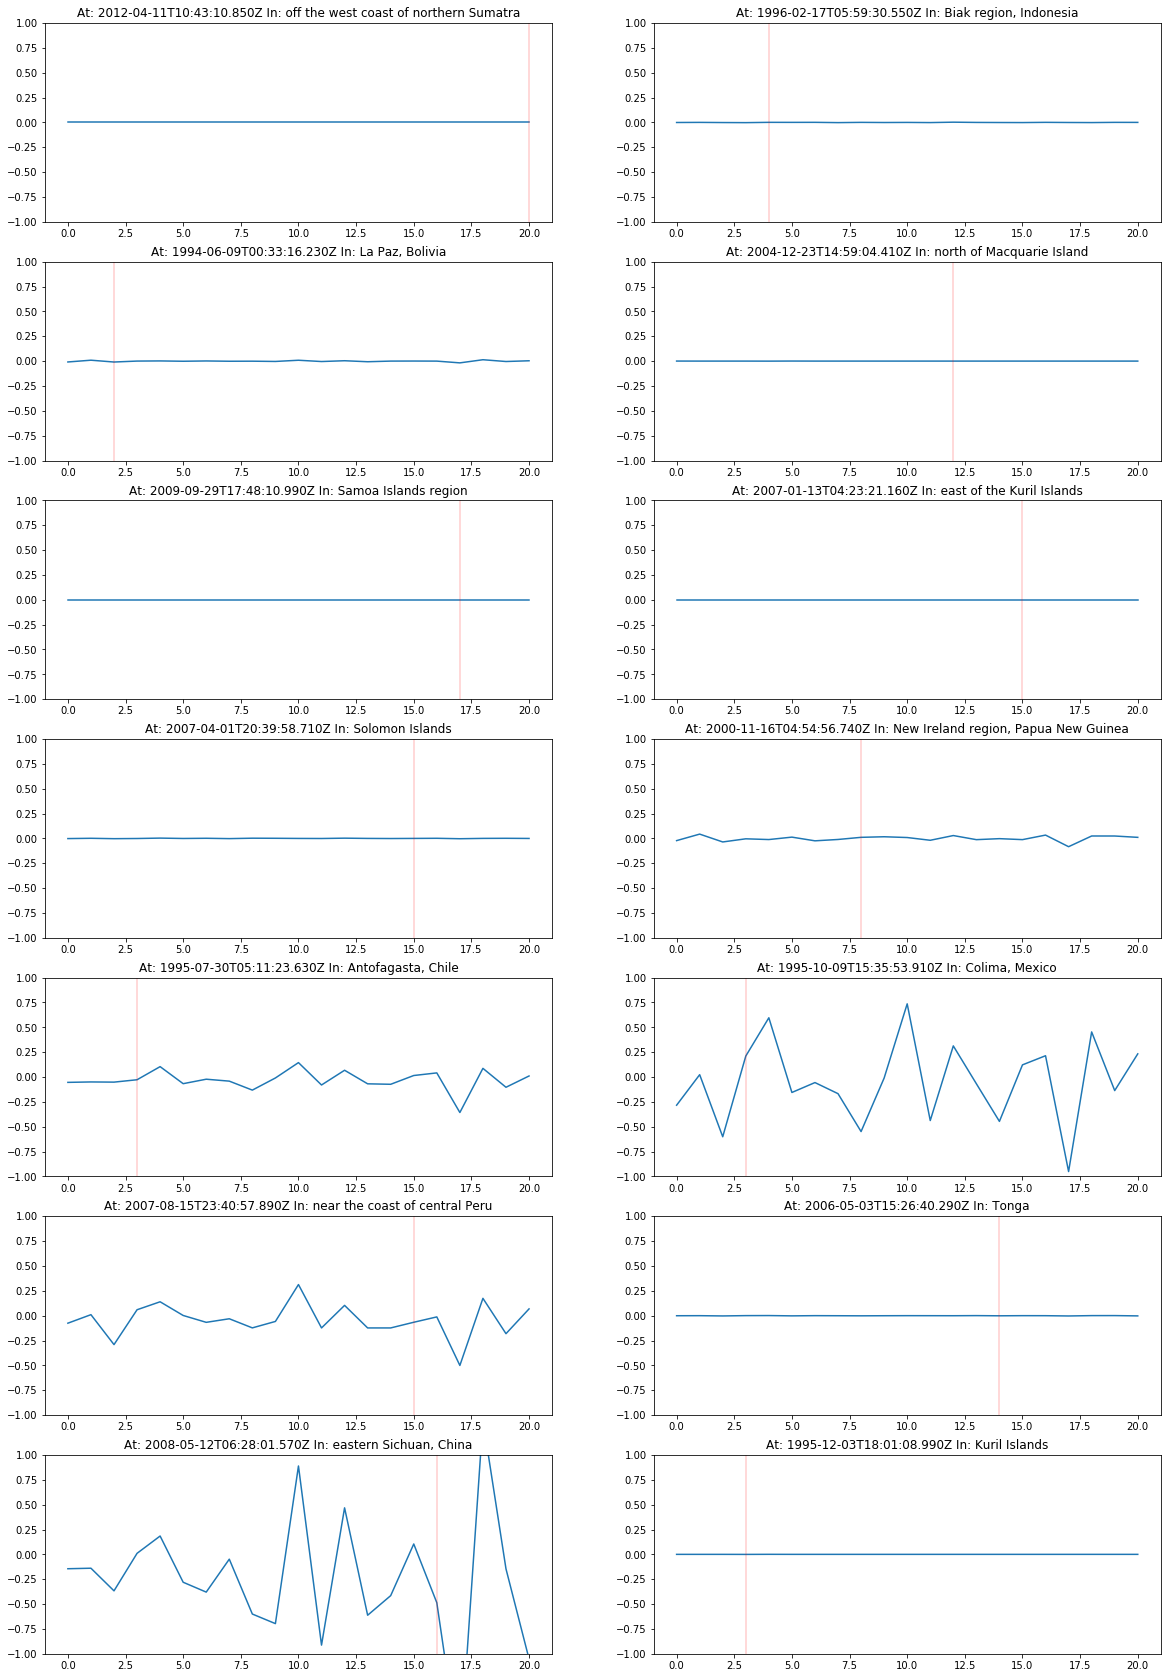

In [192]:
times_and_places = earthquakes_sorted[['time','place']]
fig, ax = plt.subplots(7,2,figsize=(20,30))
for i, axi in enumerate(ax.flat):
    i += 10
    axi.plot(series[i].mean(axis=(1,2)))
    axi.set_title('At: {} In: {}'.format(*times_and_places.iloc[i]))
    axi.set_ylim([-1,1])
    axi.axvline(x=int(times_and_places.iloc[i][0][:4])-1992, lw=.3, c='r')
    
plt.show()

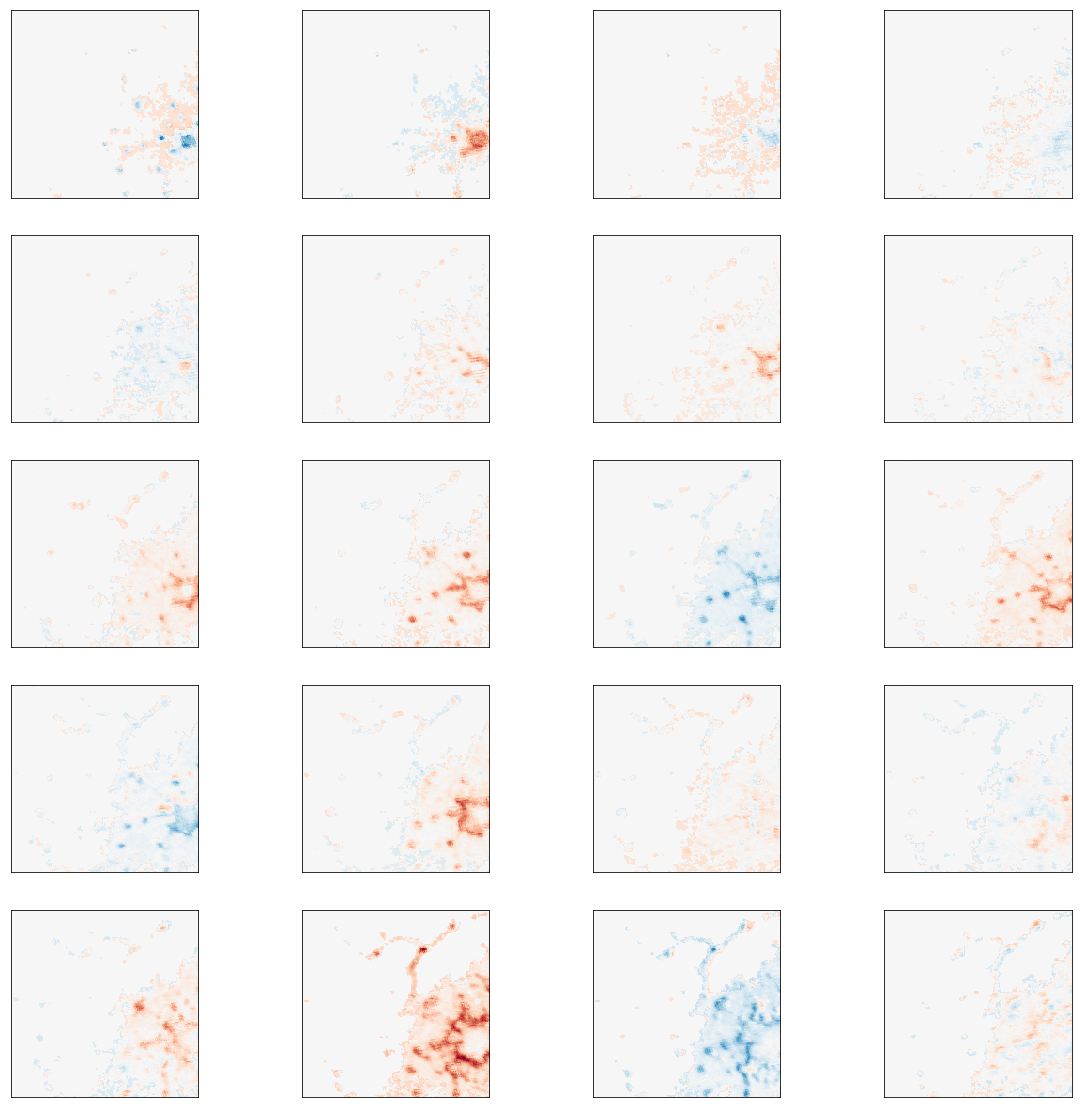

In [194]:
plot_series(series[22])

In [195]:
lags = 3
panel_data = []
for i, s in enumerate(series):
    dummy = np.zeros(len(series[i]))
    dummy[earthquakes_sorted['year'].iloc[i]-1992] = earthquakes_sorted['mag'].values[i]
    dataset = pd.DataFrame({
        'i': i,
        'year': list(range(1993,2014))
    })
    mean_luminosity_return = pd.Series(series[i].mean(axis=(1,2)))
    dataset['mean_luminosity_return_lag_0'] = mean_luminosity_return
    dataset['earthquake_dummy_lag_0'] = dummy
    for t in range(1,lags+1):
        dataset['mean_luminosity_return_lag_{}'.format(t)] = mean_luminosity_return\
            .shift(t).fillna(dataset['mean_luminosity_return_lag_{}'.format(t-1)].mean())  # >゜)))><
        dataset['earthquake_dummy_lag_{}'.format(t)] = dataset['earthquake_dummy_lag_0']\
            .shift(t).fillna(0)  # >゜)))><
    panel_data.append(dataset)
    
panel_df = pd.concat(panel_data).set_index(['i','year'])
panel_df = pd.DataFrame(normalize(panel_df), columns=panel_df.columns, index=panel_df.index)
panel = xr.Dataset.from_dataframe(panel_df)

In [210]:
feature_cols = [
    *['mean_luminosity_return_lag_{}'.format(t) for t in range(1,4)],
    *['earthquake_dummy_lag_{}'.format(t) for t in range(4)]
]
results = pd.DataFrame(columns=['mean_residuals'] + feature_cols)
for i in range(3500):
    section_series = panel.sel(i=i).to_dataframe()
    lrg = LinearRegression()
    lrg.fit(section_series[feature_cols], section_series['mean_luminosity_return_lag_0'])
    residuals = lrg.predict(section_series[feature_cols])
    results = results.append(pd.DataFrame(
        [[residuals.mean(), *lrg.coef_]],
        columns=['mean_residuals'] + feature_cols))
    
results = results.reset_index().drop('index',axis=1)
results.head()

,mean_residuals,mean_luminosity_return_lag_1,mean_luminosity_return_lag_2,mean_luminosity_return_lag_3,earthquake_dummy_lag_0,earthquake_dummy_lag_1,earthquake_dummy_lag_2,earthquake_dummy_lag_3
0,0.0507,-0.6577,-0.3752,-0.0189,-0.0847,-0.0915,0.0000,0.0000
1,-0.1592,-0.6973,-0.1827,0.0676,0.3656,0.3645,0.3633,0.3647
2,-0.1701,-0.2186,-0.1255,0.1609,0.2418,0.1968,0.2478,0.0000
3,-0.0139,-0.7132,-0.4265,-0.1397,0.0126,0.0000,0.0000,0.0000
4,-0.1555,-0.5854,-0.1987,-0.3113,0.4072,0.4057,0.4071,0.4071


In [214]:
results['earthquake_dummy_lag_0'].argmax()

1254

In [213]:
results.agg(['mean','var','std','min','max']).transpose()

,mean,var,std,min,max
mean_residuals,-0.0576,0.0041,0.0644,-0.2968,0.1224
mean_luminosity_return_lag_1,-0.3438,0.0932,0.3053,-1.4324,0.4216
mean_luminosity_return_lag_2,-0.1792,0.0656,0.2561,-1.5969,0.6820
mean_luminosity_return_lag_3,-0.0177,0.5979,0.7732,-1.9772,23.0297
earthquake_dummy_lag_0,0.1083,0.0180,0.1341,-0.5361,1.2686
earthquake_dummy_lag_1,0.1034,0.0179,0.1340,-0.5157,1.2498
earthquake_dummy_lag_2,0.0991,0.0174,0.1318,-0.3290,1.2556
earthquake_dummy_lag_3,0.0920,0.0173,0.1315,-0.4493,1.2493


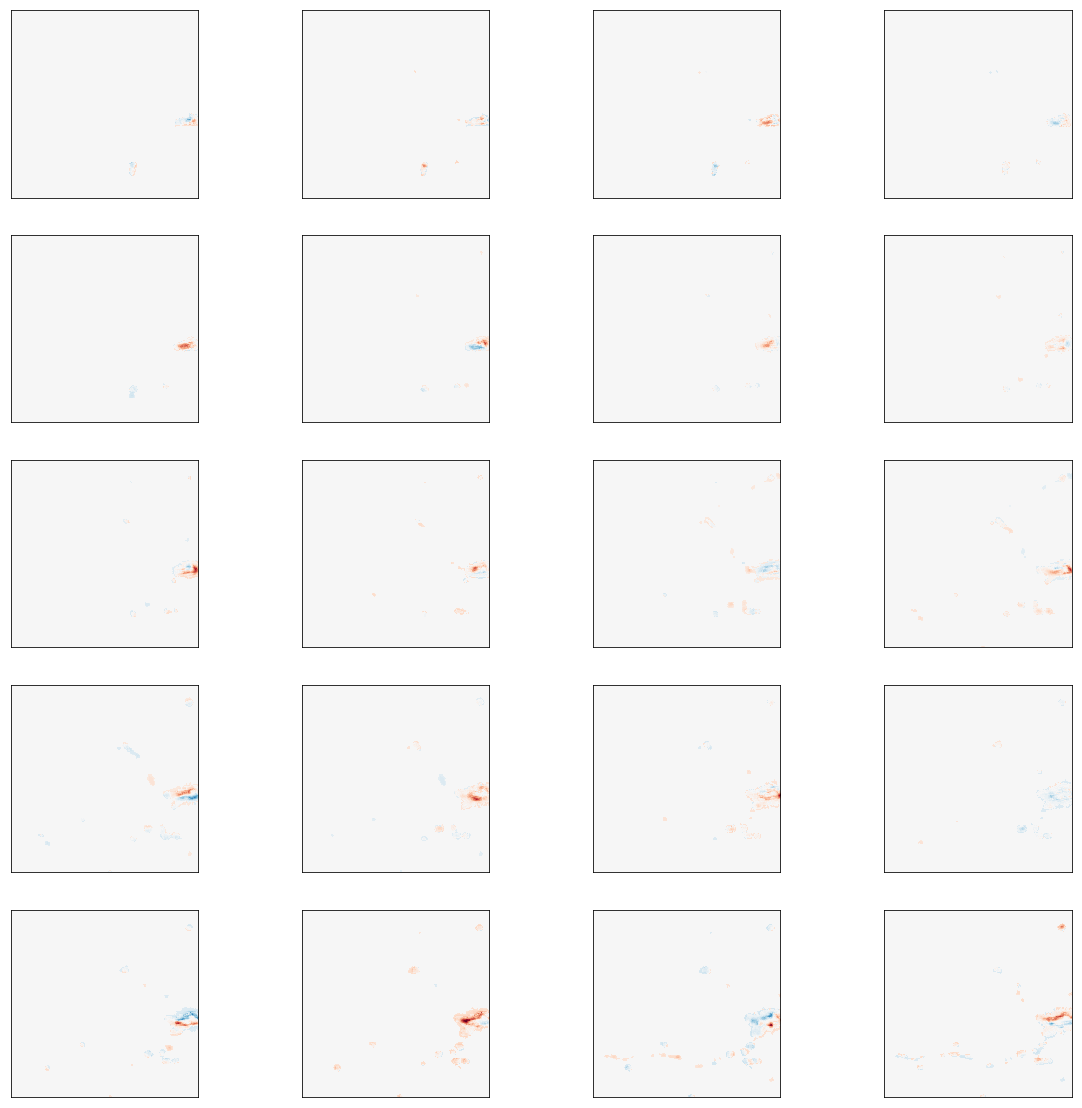

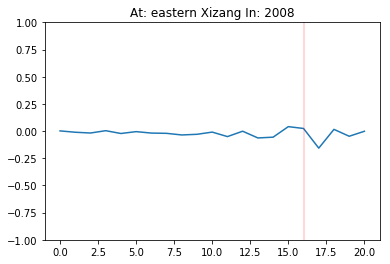

In [222]:
i = 1254
plot_series(series[i])
plt.plot(series[i].mean(axis=(1,2)))
plt.title('At: {} In: {}'.format(*earthquakes_sorted.iloc[i][['place','year']].values))
plt.ylim([-1,1])
plt.axvline(x=int(earthquakes_sorted.iloc[i][0][:4])-1992, lw=.3, c='r')